## TODO
1. Integrate Glove and BERT embeddings
2. Use attention mechanism (self-attention or normal attention) (Use neural information processing book)
    - for image 
    - for text

## Libraries

In [237]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from pickle import load
from tqdm import tqdm_notebook
import pandas as pd
import cv2
import os
from os import listdir, path
import pickle
from IPython.display import clear_output, display

In [9]:
#Preprocessing
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#VGG
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.layers import Input

#Layers
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import add
from keras.callbacks import ModelCheckpoint

In [10]:
import tensorflow as tf

In [11]:
tf.__version__

'2.0.0'

## Extracting features from Images

In [5]:
SAMPLE_SIZE = None

In [209]:
def extract_features(model, directory, num_samples=None, test_sample=None):
    
    features = dict()
    files = listdir(directory)
    files = files if num_samples is None else files[:num_samples]
    for name in tqdm_notebook(files):
        # load an image from file
        if not test_sample:
            filename = path.join(directory, name)
            image = load_img(filename, target_size=(224, 224))
        else:
            image = load_img(test_sample, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # extracting features using VGG16
        feature = model.predict(image)
        # shape = [1, 7, 7, 512]
        if test_sample:
            return feature
        
        # get image id
        image_id = name.split('.')[0]
        features[image_id] = feature.tolist()
        
    return features

def get_VGG_model():
    # loading VGG model weights
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=True, input_tensor=in_layer, weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    #model.summary()
    return model

import json
grand_features=None

def driver():
    directory = './Flickr8k_Dataset/Flicker8k_Dataset'
    model = get_VGG_model()
    
    global grand_features
    grand_features = extract_features(model, directory, SAMPLE_SIZE)

    print('Number of samples : {}'.format(len(grand_features)))
    #print("Shape of each image feature matrix: {}".format(grand_features[list(grand_features.keys())[0]].shape))

    # saving on disk
    #from pickle import dump
    #dump(grand_features, open("features.pkl", "wb"))
    import json
    with open('features.json', 'w') as f_features:
        json.dump(grand_features, f_features)
    print("Saved features on disk")


if os.path.exists('features.json'):
    print('File already exists')
    res=input('Force Redo ?')
    if res=='y':
        driver()
    else:
        grand_features = json.load(open('features.json'))
        grand_features = {key:np.array(x) for key, x in grand_features.items()}
else:
    driver()
    grand_features = {key:np.array(x) for key, x in grand_features.items()}

File already exists


KeyboardInterrupt: 

In [13]:
grand_features['3286017638_c688c83e3d'].shape

(1, 4096)

## Text Data Preparation

In [14]:
import string
import re

In [15]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [16]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
doc[:300]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the s'

In [17]:
from collections import defaultdict

def get_image_ids():
    return set(grand_features.keys())

def load_descriptions(doc):
    mapping = defaultdict(list)
    # process lines
    for line in tqdm_notebook(doc.split('\n')):
        # split line by white space
        tokens = line.split()
        
        if len(line) < 2:
            continue
        
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # remove filename from image id
        image_id = image_id.split('.')[0]
        
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        
        # fetching those image ids for which we have extracted the features
        image_ids_with_features = get_image_ids()
        
        # create the list if needed
        # TODO : Include all the descriptions and not just the first one
        # if image_id not in mapping and image_id in image_ids_with_features:
        #    mapping[image_id] = list()
            # store description
        if image_id in image_ids_with_features:
            mapping[image_id].append(image_desc)
            
    return mapping

In [17]:
descriptions = load_descriptions(doc)
descriptions

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


defaultdict(list,
            {'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
              'A girl going into a wooden building .',
              'A little girl climbing into a wooden playhouse .',
              'A little girl climbing the stairs to her playhouse .',
              'A little girl in a pink dress going into a wooden cabin .'],
             '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
              'A black dog and a tri-colored dog playing with each other on the road .',
              'A black dog and a white dog with brown spots are staring at each other in the street .',
              'Two dogs of different breeds looking at each other on the road .',
              'Two dogs on pavement moving toward each other .'],
             '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
              'A little girl is sitting

In [18]:
def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in tqdm_notebook(descriptions.items()):
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] = ' '.join(desc)

In [19]:
clean_descriptions(descriptions)
descriptions

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


defaultdict(list,
            {'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
              'girl going into wooden building',
              'little girl climbing into wooden playhouse',
              'little girl climbing the stairs to her playhouse',
              'little girl in pink dress going into wooden cabin'],
             '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
              'black dog and tricolored dog playing with each other on the road',
              'black dog and white dog with brown spots are staring at each other in the street',
              'two dogs of different breeds looking at each other on the road',
              'two dogs on pavement moving toward each other'],
             '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
              'little girl is sitting in front of large painted rainbow',
              'small girl 

In [19]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

vocabulary = to_vocabulary(descriptions)
print('Length of vocabulary : {}'.format(len(vocabulary)))

NameError: name 'descriptions' is not defined

In [20]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [21]:
def driver():
    filename = 'Flickr8k_text/Flickr8k.token.txt'
    doc = load_doc(filename)
    # parse descriptions
    descriptions = load_descriptions(doc)
    print('Loaded: %d ' % len(descriptions))
    # clean descriptions
    clean_descriptions(descriptions)
    # summarize vocabulary
    vocabulary = to_vocabulary(descriptions)
    print('Vocabulary Size: %d' % len(vocabulary))
    # save to file
    save_descriptions(descriptions, 'descriptions.txt')
driver()

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Loaded: 8091 


/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Vocabulary Size: 8763


## Loading the prepared data : Train and Test Sets

In [22]:
from pickle import load
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = defaultdict(list)
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            #if image_id not in descriptions:
            #    descriptions[image_id] = list()
                # TODO : Use defaultdict instead
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc) # each id will have multiple descriptions
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    #all_features = load(open(filename, 'rb'))
    all_features = grand_features
    # filter features
    features = {k: all_features[k] for k in dataset if k in all_features}
    return features

In [23]:
FILENAME = 'Flickr8k_text/Flickr_8k.{}Images.txt'

def get_data(mode = 'train'):
    filename = FILENAME.format(mode)
    data = load_set(filename)
    print('{}------- \nDataset: {}'.format(mode,len(data)))

    # descriptions
    descriptions = load_clean_descriptions('descriptions.txt', data)
    print('Descriptions: {}={}'.format(mode, len(descriptions)))

    # photo features
    features = load_photo_features('features.json', data)
    print('Photos: {}={}\n'.format(mode, len(features)))
    return data, descriptions, features 

traindata, train_descriptions, train_features = get_data('train')
traindata = traindata.intersection(grand_features.keys())
testdata, test_descriptions, test_features = get_data('test')
testdata = testdata.intersection(grand_features.keys())
devdata, dev_descriptions, dev_features = get_data('dev') 
devdata = devdata.intersection(grand_features.keys())

train------- 
Dataset: 6000
Descriptions: train=6000
Photos: train=6000

test------- 
Dataset: 1000
Descriptions: test=1000
Photos: test=1000

dev------- 
Dataset: 1000
Descriptions: dev=1000
Photos: dev=1000



In [25]:
train_descriptions

defaultdict(list,
            {'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
              'startseq girl going into wooden building endseq',
              'startseq little girl climbing into wooden playhouse endseq',
              'startseq little girl climbing the stairs to her playhouse endseq',
              'startseq little girl in pink dress going into wooden cabin endseq'],
             '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
              'startseq black dog and tricolored dog playing with each other on the road endseq',
              'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
              'startseq two dogs of different breeds looking at each other on the road endseq',
              'startseq two dogs on pavement moving toward each other endseq'],
             '1002674143_1b742ab4b8': ['startseq little girl covere

In [27]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    #all_desc = list()
    #for key in descriptions.keys():
    #    [all_desc.append(d) for d in descriptions[key]]
    #return all_desc
    return sum(list(descriptions.values()), [])

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def get_max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences_grand(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    count=0
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        if count==10:
            break
        count+=1
        
        for desc in desc_list:
            #print(desc)
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            #print(seq)
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                #print(in_seq, '---->', out_seq) 
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                #print(out_seq)
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, image):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        #print(desc)
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        #print(seq)
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            #print(in_seq, '---->', out_seq) 
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            #print(out_seq)
            # store
            X1.append(image)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1).astype('float32'), np.array(X2).astype('float32'), np.array(y).astype('float32')

In [28]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = get_max_length(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 34


In [29]:
def data_generator(descriptions, tokenizer, max_length, imageids, num_photos_per_batch):
    # loop for ever over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for image_id in imageids:
            n+=1
            # create word sequences
            desc = descriptions[image_id]
            # desc contains multiple descriptions for the image
            #print(image_id)
            image = grand_features[image_id][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc, image)
            X1.extend(in_img)
            X2.extend(in_seq)
            y.extend(out_word)
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [29]:
def data_generator2(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Creating Data Generator for Train and Dev sets

In [74]:
num_photos_per_batch = 3
train_generator = data_generator(descriptions, tokenizer, max_length, traindata, num_photos_per_batch)
dev_generator = data_generator(descriptions, tokenizer, max_length, devdata, num_photos_per_batch)

In [82]:
# prepare train sequences
X1train, X2train, ytrain = create_sequences_grand(tokenizer, max_length, train_descriptions,train_features)
# prepare test sequences
X1dev, X2dev, ydev = create_sequences_grand(tokenizer, max_length, dev_descriptions,dev_features)

In [110]:
for key, value in tqdm_notebook(grand_features.items()):
    if len(value.shape)!=4:
        print('something is off')

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


## Defining the model

In [30]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    #inputs1 = Input(shape=(7,7,512))
    #inp1 = Conv2D(512, (3,3), activation='relu')(inputs1)
    #inp11 = MaxPooling2D(pool_size=(2, 2))(inp1)
    #inp2 = Flatten()(inp11)
    
    # feature extractor model
    #inputs1 = Input(shape=(7,7,512), dtype='float32')
    #inp2 = Flatten(dtype='float32')(inputs1)
    #inp2 = Dense(4096, activation='relu', dtype='float32')(inp2)
    
    # feature extractor model
    inputs1 = Input(shape=(4096,), dtype='float32')
    
    #inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu', dtype='float32')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,), dtype='float32')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, dtype='float32')(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu', dtype='float32')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', dtype='float32')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

### WITHOUT Generator

In [31]:
# prepare train sequences
X1train, X2train, ytrain = create_sequences_grand(tokenizer, max_length, train_descriptions,train_features)
# prepare test sequences
X1dev, X2dev, ydev = create_sequences_grand(tokenizer, max_length, dev_descriptions,dev_features)

# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=100, verbose=2, callbacks=[checkpoint],
          validation_data=([X1dev, X2dev], ydev))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 566 samples, validate on 565 samples
Epoch 1/100


KeyboardInterrupt: 

### WITH Generator

In [33]:
# Reinitializing the generators
epochs = 100
num_photos_per_batch = 3
steps = len(train_descriptions)//num_photos_per_batch

train_generator = data_generator(descriptions, tokenizer, max_length, traindata, num_photos_per_batch)
dev_generator = data_generator(descriptions, tokenizer, max_length, devdata, num_photos_per_batch)

In [ ]:
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=False)
# fit model
for i in range(epochs):
    print("EPOCH: {}".format(i))
    train_generator = data_generator(descriptions, tokenizer, max_length, traindata, num_photos_per_batch)
    model.fit_generator(generator=train_generator, 
                        verbose=1, 
                        steps_per_epoch=steps)
    if i%10==0:
        model.save('./weights/model_' + str(i) + '.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_4[0][0]                    
____________________________________________________________________________________________

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
2000/2000 [==============================] - 444s 222ms/step - loss: 5.1594
EPOCH: 1
Epoch 1/1
2000/2000 [==============================] - 459s 229ms/step - loss: 4.1241
EPOCH: 2
Epoch 1/1
2000/2000 [==============================] - 450s 225ms/step - loss: 3.7551
EPOCH: 3
Epoch 1/1
2000/2000 [==============================] - 433s 217ms/step - loss: 3.5192
EPOCH: 4
Epoch 1/1
2000/2000 [==============================] - 430s 215ms/step - loss: 3.3404
EPOCH: 5
Epoch 1/1
2000/2000 [==============================] - 435s 218ms/step - loss: 3.1995
EPOCH: 6
Epoch 1/1
2000/2000 [==============================] - 432s 216ms/step - loss: 3.0891
EPOCH: 7
Epoch 1/1
2000/2000 [==============================] - 430s 215ms/step - loss: 3.0016
EPOCH: 8
Epoch 1/1
2000/2000 [==============================] - 432s 216ms/step - loss: 2.9179
EPOCH: 9
Epoch 1/1
1093/2000 [===============>..............] - ETA: 3:17 - loss: 2.8583

## Prediction

In [5]:
from numpy import argmax
from pickle import load
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [2]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [2]:
import keras

Using TensorFlow backend.


In [3]:
keras.__version__

'2.3.1'

In [162]:
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for _ in range(max_length): #why not more than max_length
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        #if word is None: #how is this possible ?
        #    break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [259]:
# load the model
# filename = './weights/without_glove/model_60.h5'
filename = './weights/with_glove/model_20.h5'
model = load_model(filename)

## Random test sample

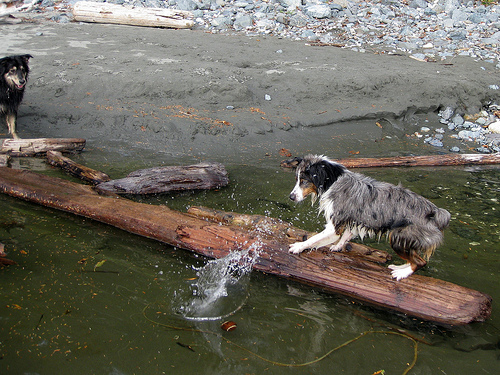

In [200]:
from PIL import Image
import numpy as np
test_sample = np.random.choice(list(test_features.keys()))
Image.open('./Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg'.format(test_sample))

In [201]:
sample_features = test_features[test_sample]
pred = generate_desc(model, tokenizer, sample_features, max_length)
cleanup_summary(pred)

'sniffs tree stump in the water whist it is standing on the beach as it is being squirted by another dog is tied by jet of water from the water to grab stick in'

## Random custom sample

In [260]:
directory = './Flickr8k_Dataset/Flicker8k_Dataset'
model_VGG=get_VGG_model()

In [1]:
test_sample = '/home/hs/Desktop/Projects/ImageCaptioning/test_samples/10.jpeg'
display(Image.open(test_sample))
test_features=extract_features(model_VGG, directory, test_sample=test_sample)
pred = generate_desc(model, tokenizer, test_features, max_length)
cleanup_summary(pred)

NameError: name 'Image' is not defined